# Setup

In [1]:
# !pip install -U -q segmentation-models
# !pip install -q tensorflow==2.1
# !pip install -q keras==2.3.1
# !pip install -q tensorflow-estimator==2.1.

# ## Imports libs
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ["SM_FRAMEWORK"] = "tf.keras"

# from tensorflow import keras
# import segmentation_models as sm

In [455]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter
from keras.preprocessing import sequence
import random
import matplotlib.pyplot as plt

In [3]:
def create_letter_mapping(all_words):
    letter_li = []
    
    # Get unique letters in the data
    for word in all_words:
        for letter in word:
            letter_li.append(letter)
    
    # order letters by most common
    most_common = Counter(letter_li).most_common()
    letter_li = []
    for elem in most_common:
        letter_li.append(elem[0])
    
    # Map each letter to an integer
    letter_dict = {}
    for idx, letter in enumerate(letter_li):
        if letter_dict != '':
            letter_dict[letter] = idx + 1
        else:
            letter_dict[letter] = 0
    
    return letter_dict

def letter_to_number(word_li, letter_dict):
    return_li = []
    for letter in word_li:
        return_li.append(letter_dict[letter])
        
    return return_li

def pad_list(letter_li, pad_num=25):
    curr_len = len(letter_li)
    new_len = 25 - curr_len
    zeroes = [0] * new_len
    zeroes.extend(letter_li)
    return zeroes

# Fixing Language Groups

In [194]:
lan_df = pd.read_csv('language_data.csv')

In [195]:
lan_df.fillna('Other', inplace=True)

In [247]:
lan_df.loc[lan_df['full_name'].str.contains('English'), 'Group'] = 'Germanic'
lan_df.loc[lan_df['full_name'].str.contains('Dutch'), 'Group'] = 'Germanic'
lan_df.loc[lan_df['full_name'].str.contains('Norse'), 'Group'] = 'Germanic'
lan_df.loc[lan_df['full_name'].str.contains('Germ'), 'Group'] = 'Germanic'

lan_df.loc[lan_df['full_name'].str.contains('French'), 'Group'] = 'Latin'
lan_df.loc[lan_df['full_name'].str.contains('Greek'), 'Group'] = 'Greek'
lan_df.loc[lan_df['full_name'].str.contains('Hebrew'), 'Group'] = 'Other'

lan_df.loc[lan_df['full_name'] == 'Sanskrit', 'Group'] = 'Indo-Aryan'
lan_df.loc[lan_df['full_name'] == 'Hindi', 'Group'] = 'Indo-Aryan'

lan_df = lan_df[lan_df['Group'] != 'Arabic']
lan_df = lan_df[lan_df['Group'] != 'Turkish']
lan_df = lan_df[lan_df['Group'] != 'Indo-Aryan']


lan_df = lan_df[lan_df['Group'] != 'Other']

# Date Cleanup

In [248]:
lan_df.reset_index(inplace=True,drop=True)

In [249]:
group_dict = {}
for idx, value in enumerate(lan_df.Group.unique()):
    group_dict[value] = idx
    
lan_df['group_int'] = lan_df['Group'].apply(lambda x: group_dict[x])

In [250]:
group_dict

{'Germanic': 0, 'Greek': 1, 'Latin': 2, 'Japanese': 3}

In [251]:
lan_df['letter_li'] = lan_df['word'].apply(lambda x: list(x))

In [252]:
map_dict = create_letter_mapping(lan_df['word'].values)

In [253]:
lan_df['letter_ints'] = lan_df['letter_li'].apply(lambda x: pad_list(letter_to_number(x, map_dict)))

In [254]:
SHAPE = lan_df.shape[0]

In [255]:
word_arr = np.empty(SHAPE, dtype=list)
origin_arr = np.empty(SHAPE, dtype=int)

In [256]:
for i in range(SHAPE):
    word_arr[i] = lan_df.loc[i, 'letter_ints']
    origin_arr[i] = lan_df.loc[i, 'group_int']

In [257]:
# pad array so that all words have length of 25
word_arr = sequence.pad_sequences(word_arr, 25)

In [258]:
# Develop random index for train test split
random.seed(0)
rng = np.arange(SHAPE)
random.shuffle(rng)

In [411]:
train_len = int(SHAPE * 0.7)
train_idx = rng[:train_len]
test_idx = rng[train_len:]

In [412]:
X_train, y_train = word_arr[train_idx], origin_arr[train_idx]
X_test, y_test = word_arr[test_idx], origin_arr[test_idx]

# Models

In [413]:
embedding_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(map_dict) + 1, 64),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(len(group_dict), activation="softmax")
])

In [414]:
# classes = len(group_dict)
# embed_dims = 32
# stack_model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(len(map_dict) + 1, embed_dims),
#     tf.keras.layers.LSTM(64, return_sequences=True),
#     tf.keras.layers.LSTM(32, return_sequences=False),
#     tf.keras.layers.Dense(classes, activation="softmax")
# ])

In [415]:
embedding_model.compile(loss="sparse_categorical_crossentropy",optimizer="rmsprop",metrics=['acc'])
history = embedding_model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Train on 31271 samples, validate on 7818 samples
Epoch 1/10
31271/31271 [==============================] - 22s 716us/sample - loss: 0.7694 - acc: 0.6613 - val_loss: 0.7188 - val_acc: 0.6842
Epoch 2/10
31271/31271 [==============================] - 27s 856us/sample - loss: 0.6840 - acc: 0.6997 - val_loss: 0.6619 - val_acc: 0.7160
Epoch 3/10
31271/31271 [==============================] - 24s 765us/sample - loss: 0.6471 - acc: 0.7176 - val_loss: 0.6403 - val_acc: 0.7278
Epoch 4/10
31271/31271 [==============================] - 23s 743us/sample - loss: 0.6180 - acc: 0.7330 - val_loss: 0.6329 - val_acc: 0.7242
Epoch 5/10
31271/31271 [==============================] - 25s 787us/sample - loss: 0.5907 - acc: 0.7484 - val_loss: 0.6085 - val_acc: 0.7386
Epoch 6/10
31271/31271 [==============================] - 24s 760us/sample - loss: 0.5702 - acc: 0.7578 - val_loss: 0.5811 - val_acc: 0.7549
Epoch 7/10
31271/31271 [==============================] - 22s 718us/sample - loss: 0.5496 - acc: 0.7682 -

In [295]:
# stack_model.compile(loss="sparse_categorical_crossentropy",optimizer="rmsprop",metrics=['acc'])
# history_1 = embedding_model.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Predicting Individual Words

In [416]:
def get_word_prediction(test_word, model):
    temp = pad_list(letter_to_number(list(test_word), map_dict))
    temp = model.predict(np.array([temp]))
    temp_df = pd.DataFrame(data={'group':[elem for elem in group_dict.keys()], 'probability' : temp[0] * 100})
    return temp_df

In [436]:
get_word_prediction('consume', embedding_model)

,group,probability
0,Germanic,4.412041
1,Greek,0.632197
2,Latin,94.553635
3,Japanese,0.402131


In [424]:
preds = embedding_model.predict(X_test)

In [437]:
preds[2]

array([1.4873733e-01, 4.9757056e-02, 8.0140561e-01, 1.0004165e-04],
      dtype=float32)

In [425]:
def convert_prediction(pred_list):
    max_value = -100
    max_idx = -1
    for idx,value in enumerate(pred_list):
        if value > max_value:
            max_value = value
            max_idx = idx
    
    return max_idx

In [438]:
result_list = []
germanic_li = []
for elem in preds:
    result_list.append(convert_prediction(elem))
    germanic_li.append(elem[2])

In [440]:
result_df = pd.DataFrame(data={'y_actual': y_test, 
        'y_pred': result_list,
         'prob_germanic' : germanic_li})
result_df['correct'] =  1.0 * (result_df['y_actual'] == result_df['y_pred'])

0.7760401122187071

In [448]:
result_df['is_germanic'] = result_df['y_actual'] == 2

In [483]:
avg_li = []
pred_li = []
for x in range(0,100,10):
    num1, num2 = x, x + 10
    avg_li.append((num1+num2)/2)
    pred_li.append(result_df.loc[(result_df['prob_germanic'] >= num1 / 100) & 
               (result_df['prob_germanic'] <= num2 / 100), 'is_germanic'].mean() * 100)

In [484]:
pred_li

[6.73385249656436,
 20.61211742660837,
 31.06796116504854,
 40.92165898617511,
 51.6,
 58.605664488017425,
 63.55511420059583,
 73.5973597359736,
 82.02368137782562,
 92.34817813765183]

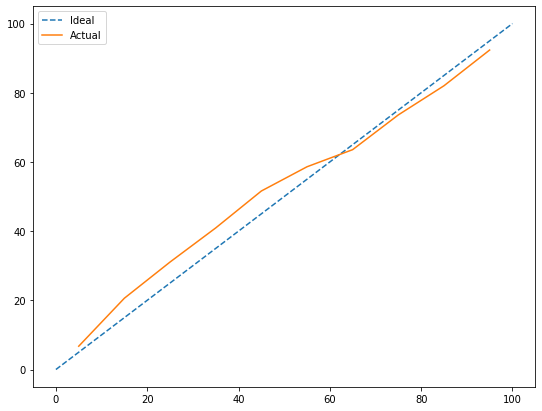

In [486]:
plt.rcParams["figure.figsize"] = (9,7)
plt.plot([0,100], [0,100], label='Ideal', linestyle='--',)
plt.plot(avg_li, pred_li, label='Actual')
plt.legend()

In [449]:
result_df.loc[(result_df['prob_germanic'] >= 0) & 
               (result_df['prob_germanic'] < 0.10), 'is_germanic'].mean()

0.0673385249656436

In [451]:
result_df.loc[(result_df['prob_germanic'] >= 0.1) & 
               (result_df['prob_germanic'] < 0.2), 'is_germanic'].mean()

0.2061211742660837

Counter({2: 7843, 0: 7711, 1: 1090, 3: 109})